In [1]:
import os

import numpy as np
import pandas as pd
from os.path import join
from tqdm import tqdm
import matplotlib.pyplot as plt
from project import download_lichess_pgn
if os.getcwd().split('\\')[-1] != 'irl-chess':
    os.chdir('../')

C:\Users\toell\AppData\Local\Temp\ipykernel_2760\4062044318.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
n_files = np.inf
websites_filepath = join(os.getcwd(), 'downloads', 'lichess_websites.txt')
file_path_data = join(os.getcwd(), 'data', 'raw')

datapaths = download_lichess_pgn(websites_filepath, file_path_data, n_files=n_files, overwrite=False)



-------------------  1/12  -------------------


C:\Users\toell\OneDrive\Documents\GitHub\irl-chess\data\processed\lichess_db_standard_rated_2013-01.csv already exists and was not changed
Time taken: 0.00 seconds for file
Time taken: 0.00 seconds in total


-------------------  2/12  -------------------


C:\Users\toell\OneDrive\Documents\GitHub\irl-chess\data\processed\lichess_db_standard_rated_2013-02.csv already exists and was not changed
Time taken: 0.00 seconds for file
Time taken: 0.00 seconds in total


-------------------  3/12  -------------------


C:\Users\toell\OneDrive\Documents\GitHub\irl-chess\data\processed\lichess_db_standard_rated_2013-03.csv already exists and was not changed
Time taken: 0.00 seconds for file
Time taken: 0.00 seconds in total


-------------------  4/12  -------------------


C:\Users\toell\OneDrive\Documents\GitHub\irl-chess\data\processed\lichess_db_standard_rated_2013-04.csv already exists and was not changed
Time taken: 0.00 seconds for file
Ti

In [3]:
df = pd.read_csv(datapaths[0], index_col=None)

for path in tqdm(datapaths):
    df_ = pd.read_csv(path, index_col=None)
    df = pd.concat((df, df_), axis=0)


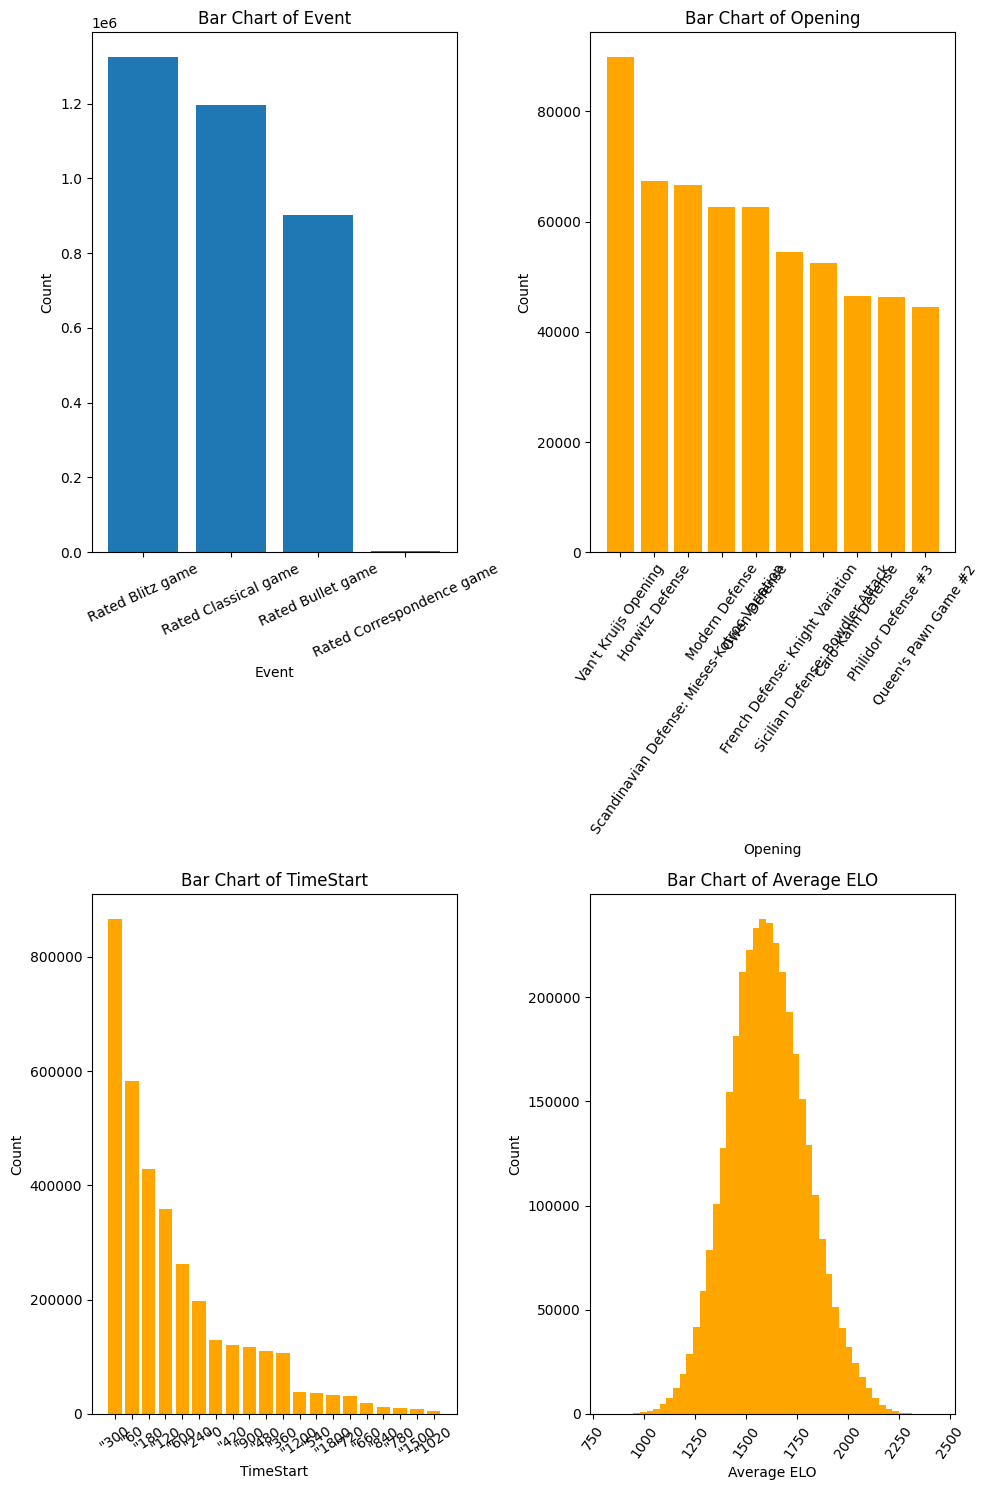

In [5]:
n_event = 4
n_time = 20
n_opening = 10
fig, axes = plt.subplots(2, 2, figsize=(10, 15))

plot_val = 'Event' 
class_counts_event = df[plot_val].value_counts()[:n_event]
axes[0, 0].bar(class_counts_event.index[:n_event], class_counts_event.values)
axes[0, 0].set_xlabel(plot_val)
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Bar Chart of ' + plot_val)
axes[0, 0].tick_params(axis='x', rotation=25)  # Rotate x-axis labels

plot_val = 'TimeStart'
class_counts_time_control = df[plot_val].value_counts()[:n_time]
axes[1, 0].bar(class_counts_time_control.index[:n_time], class_counts_time_control.values, color='orange')
axes[1, 0].set_xlabel(plot_val)
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title(f'Bar Chart of {plot_val}')
axes[1, 0].tick_params(axis='x', rotation=35)  # Rotate x-axis labels

plot_val = 'Opening'
class_counts_opening = df[plot_val].value_counts()[:n_opening]
axes[0, 1].bar(class_counts_opening.index[:n_opening], class_counts_opening.values, color='orange')
axes[0, 1].set_xlabel(plot_val)
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Bar Chart of ' + plot_val)
axes[0, 1].tick_params(axis='x', rotation=55)  # Rotate x-axis labels

plot_val = 'Average ELO'
mask_valid_elo = df[['WhiteElo']].values == '?'
mask_ = df[['BlackElo']].values == '?'
mask_valid_elo = np.logical_not((mask_valid_elo + mask_).flatten())
axes[1, 1].hist(df[['WhiteElo', 'BlackElo']].values[mask_valid_elo].astype(int).mean(axis=1), bins=50, color= 'orange')
axes[1, 1].set_xlabel(plot_val)
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Bar Chart of ' + plot_val)
axes[1, 1].tick_params(axis='x', rotation=55)  # Rotate x-axis labels

# Adjust layout
plt.tight_layout()
plt.show()

Chess time control notation states the number of seconds players start with + the increment per move
so 60 + 0 means each player only has 60 seconds for the entire game and
300 + 8 means 6 minutes to start and 8 seconds per move made. 

In [5]:
df.columns

Index(['Event', 'Site', 'White', 'Black', 'Result', 'UTCDate', 'UTCTime',
       'WhiteElo', 'BlackElo', 'WhiteRatingDiff', 'BlackRatingDiff', 'ECO',
       'Opening', 'TimeStart', 'TimeIncrement', 'Termination', 'Moves'],
      dtype='object')

In [22]:
from project import get_best_move    
from time import time

def softmax_choice(x):
    """
    Returns an index based on the softmax of x
    :param x: 
    :return: 
    """
    x_soft = np.exp(x) / np.sum(np.exp(x))
    np.random.choice(np.arange(x_soft.shape[0]), p=x_soft)
    return x_soft

def prob_dist(R, energy, alpha, prior=lambda R: 1):
    prob = np.exp(alpha * energy) * prior(R)
    return prob

def policy_walk_depth(R, boards, moves, delta=1e-3, epochs=10, depth_max=3, alpha=2e-2, time_max=np.inf):
    depth_dist = np.ones(depth_max)
    start = time()
    for epoch in tqdm(range(epochs)):
        add = np.random.rand(depth_dist.shape[0]).astype(depth_dist.dtype) * (delta / 2)
        depth_dist_ = depth_max + add
        Q_moves = np.zeros(len(boards))
        Q_policy = np.zeros(len(boards))
        i = 0
        energy_new, energy_old = 0, 0
        for board, move in tqdm(zip(boards, moves), total=len(boards)):
            board.push_san(move)
            _, Q_old = get_best_move(board=board, R=R, depth=softmax_choice(depth_dist))
            _, Q_new = get_best_move(board=board, R=R, depth=softmax_choice(depth_dist_))
            board.pop()
            
            Q_moves[i] = Q_old
            Q_policy[i] = Q_new
            
            energy_old += Q_old
            energy_new += Q_new

            i += 1
            prob = min(1, prob_dist(depth_dist, energy_new, alpha=alpha)/prob_dist(depth_dist_, energy_old, alpha=alpha))
            if np.sum(Q_policy < Q_moves):
                if np.random.rand(1).item() < prob:
                    depth_dist = depth_dist_
            if start - time() > time_max:
                return depth_dist
    return depth_dist

In [ ]:
from project import get_best_move, Searcher, Position, initial, sunfish_move, sunfish_move_to_str, pst, calculate_heuristics

In [20]:
import chess

board = chess.Board()
for move in df['Moves'].values[0].split(',')[:-2]:
    board.push_san(move)
    print(board)
    print()

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R

r n b q k b n r
p p p p . p p p
. . . . p . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R

r n b q k b n r
p p p p . p p p
. . . . p . . .
. . . . . . . .
. . . P P . . .
. . . . . . . .
P P P . . P P P
R N B Q K B N R

r n b q k b n r
p . p p . p p p
. p . . p . . .
. . . . . . . .
. . . P P . . .
. . . . . . . .
P P P . . P P P
R N B Q K B N R

r n b q k b n r
p . p p . p p p
. p . . p . . .
. . . . . . . .
. . . P P . . .
P . . . . . . .
. P P . . P P P
R N B Q K B N R

r n . q k b n r
p b p p . p p p
. p . . p . . .
. . . . . . . .
. . . P P . . .
P . . . . . . .
. P P . . P P P
R N B Q K B N R

r n . q k b n r
p b p p . p p p
. p . . p . . .
. . . . . . . .
. . . P P . . .
P . N . . . . .
. P P . . P P P
R . B Q K B N R

r n . q k b . r
p b p p . p p p
. p . . p . . n
. . . . . . . .
. . . P P . . .
P . N . . . . .
.

In [12]:
import re

def parse_game(input_string, included_keys):
    pattern = r'\[([^\]]+)\]'

    # Use regular expression to find all matches within square brackets
    matches = re.findall(pattern, input_string)

    # Specify the keys you want to include
    # included_keys = ['Event', 'Site', 'Date', 'White', 'Black', 'Result', 'UTCDate',
    #                  'UTCTime', 'WhiteElo', 'BlackElo', 'WhiteRatingDiff', 'BlackRatingDiff',
    #                  'WhiteTitle', 'ECO', 'Opening', 'TimeControl', 'Termination']

    # Create a list to store the extracted values
    data_list = []
    for match in matches:
        key, value = map(str.strip, match.split(' ', 1))

        # Include only the specified keys
        if key.lower() == 'timecontrol':
            data_list += [el.replace('"', '') for el in value.split('+')]
        elif key in included_keys:
            # Remove double quotes from the value
            value = value.replace('"', '')
            data_list.append(value)

    return data_list


# Example usage
input_string = """
[Event "Rated Bullet tournament https://lichess.org/tournament/yc1WW2Ox"]
[Site "https://lichess.org/PpwPOZMq"]
[Date "2017.04.01"]
[Round "-"]
[White "Abbot"]
[Black "Costello"]
[Result "0-1"]
[UTCDate "2017.04.01"]
[UTCTime "11:32:01"]
[WhiteElo "2100"]
[BlackElo "2000"]
[WhiteRatingDiff "-4"]
[BlackRatingDiff "+1"]
[WhiteTitle "FM"]
[ECO "B30"]
[Opening "Sicilian Defense: Old Sicilian"]
[TimeControl "300+0"]
[Termination "Time forfeit"]
"""
columns = ['Event', 'Site', 'Date', 'White', 'Black', 'Result', 'UTCDate',
                     'UTCTime', 'WhiteElo', 'BlackElo', 'WhiteRatingDiff', 'BlackRatingDiff',
                     'WhiteTitle', 'ECO', 'Opening', 'TimeControl', 'Termination']
result = parse_game(input_string, columns)
print(result)


['Rated Bullet tournament https://lichess.org/tournament/yc1WW2Ox', 'https://lichess.org/PpwPOZMq', '2017.04.01', 'Abbot', 'Costello', '0-1', '2017.04.01', '11:32:01', '2100', '2000', '-4', '+1', 'FM', 'B30', 'Sicilian Defense: Old Sicilian', '300', '0', 'Time forfeit']


In [9]:
print(result[0])

Rated Bullet tournament https://lichess.org/tournament/yc1WW2Ox
